# 1. Setup

### 1.1 Pip


In [33]:
!pip install labelme albumentations ipywebrtc

In [ ]:
!mkdir data
!mkdir aug_data

%cd data
!mkdir labels images train test val

%cd train
!mkdir labels images
%cd ..

%cd test
!mkdir labels images
%cd ..

%cd val
!mkdir labels images
%cd ..
%cd ..
%cd aug_data
!mkdir train test val

%cd train
!mkdir labels images
%cd ..

%cd test
!mkdir labels images
%cd ..

%cd val
!mkdir labels images
%cd ..
%cd ..


mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘aug_data’: File exists
/content/data
mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘val’: File exists
/content/data/train
mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘images’: File exists
/content/data
/content/data/test
mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘images’: File exists
/content/data
/content/data/val
mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘images’: File exists
/content/data
/content
/content/aug_data
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
mkdir: cannot create directory ‘val’: File exists
/content/aug_data/train


### 1.2 prise des photos

In [ ]:
import os
import time
import uuid
import cv2
from IPython.display import Image, display, clear_output

import ipywebrtc as webrtc

In [ ]:
IMAGES_PATH = 'data/images'
os.makedirs(IMAGES_PATH, exist_ok=True)
number_images = 5  # choisir le nombre d'image

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
def capture_images():
    # Start the camera
    camera = webrtc.CameraStream(constraints={'facing_mode': 'user'})
    display(camera)

    # Capture images using the camera
    for imgnum in range(number_images):
        print('Collecting image {}'.format(imgnum))

        # Capture image from the webcam
        img_widget = webrtc.Image()
        img_widget.from_stream(camera)
        img_data = img_widget.value
        img_array = np.asarray(bytearray(img_data), dtype=np.uint8)
        img_cv2 = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

        # Save the image
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, cv2.cvtColor(img_cv2, cv2.COLOR_RGB2BGR))

        # Display the captured photo
        display(Image(data=img_data, format='jpeg', width=300, height=300))

        # Wait for a short duration before capturing the next image
        time.sleep(0.5)

    # Close the camera stream
    camera.close()
    print('Image capture completed.')

# Call the function to capture images
#capture_images()


# 2. Chargement des images


### 2.1 Import

In [34]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [35]:
# Limite les ressources prises sur le GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [36]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Pipeline

In [37]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [38]:
images.as_numpy_iterator().next()

b'data/images/29963c44-af41-11ee-9a72-2cd26bf08388.jpg'

In [39]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [40]:
images = images.map(load_image)

In [41]:
images.as_numpy_iterator().next()

array([[[200, 207, 200],
        [203, 210, 203],
        [203, 213, 205],
        ...,
        [114, 125, 119],
        [115, 126, 122],
        [115, 127, 123]],

       [[203, 210, 203],
        [203, 213, 205],
        [203, 213, 205],
        ...,
        [114, 123, 118],
        [114, 125, 121],
        [114, 126, 122]],

       [[202, 211, 206],
        [204, 213, 208],
        [204, 214, 206],
        ...,
        [114, 123, 118],
        [115, 124, 121],
        [116, 127, 123]],

       ...,

       [[152, 155, 146],
        [151, 154, 145],
        [141, 143, 138],
        ...,
        [112, 127, 120],
        [114, 129, 122],
        [115, 130, 123]],

       [[150, 151, 145],
        [150, 153, 146],
        [139, 141, 138],
        ...,
        [110, 130, 121],
        [113, 130, 124],
        [114, 131, 125]],

       [[145, 146, 140],
        [148, 149, 144],
        [138, 140, 137],
        ...,
        [110, 131, 122],
        [114, 131, 125],
        [114, 131, 125]]

In [42]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 Test sur des images randoms

In [43]:
image_generator = images.batch(4).as_numpy_iterator()

In [44]:
plot_images = image_generator.next()

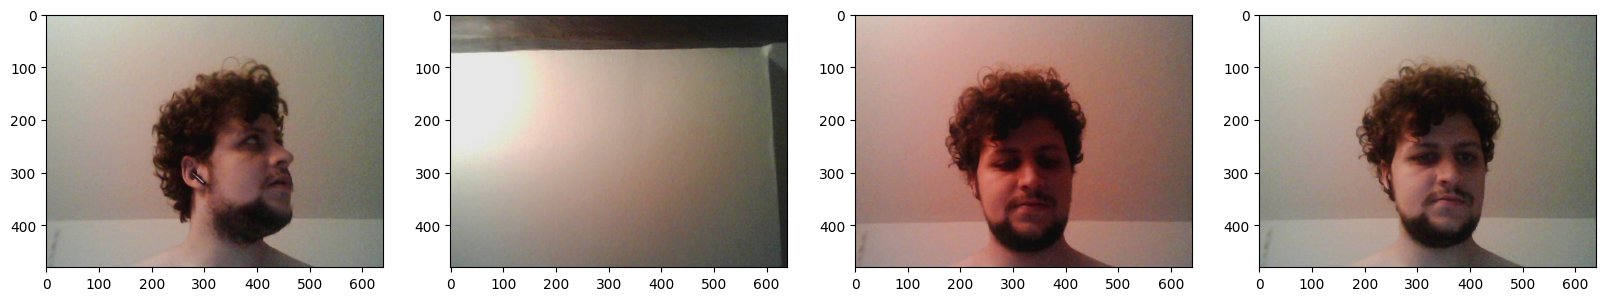

In [45]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Repartition des données

### 3.1 Répartir manuellement les données

In [46]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('/content/data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

# 4. Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [47]:
import albumentations as alb

In [48]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

### 4.2 Image test

In [49]:
img = cv2.imread(os.path.join('data','train', 'images','222983e6-af41-11ee-8c36-2cd26bf08388.jpg'))

In [50]:
with open(os.path.join('data', 'train', 'labels', '222983e6-af41-11ee-8c36-2cd26bf08388.json'), 'r') as f:
    label = json.load(f)

In [51]:
label['shapes'][0]['points']

[[204.11764705882354, 212.94117647058823], [465.56939139292086, 479.0]]

### 4.3 Extraction coordonnées

coordonnées pascal_voc


In [52]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [53]:
coords

[204.11764705882354, 212.94117647058823, 465.56939139292086, 479.0]

cordonnées albumentations = divisé par les dimensions de l'image


In [54]:
coords = list(np.divide(coords, [640,480,640,480]))

In [55]:
coords

[0.3189338235294118,
 0.44362745098039214,
 0.7274521740514388,
 0.9979166666666667]

### 4.4 Visualisation du résultat


In [56]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [57]:
augmented['bboxes'][0][2:]

(0.9041830065359477, 0.5467973856209151)

In [58]:
augmented['bboxes']

[(0.32317913023795375, 0.0, 0.9041830065359477, 0.5467973856209151)]

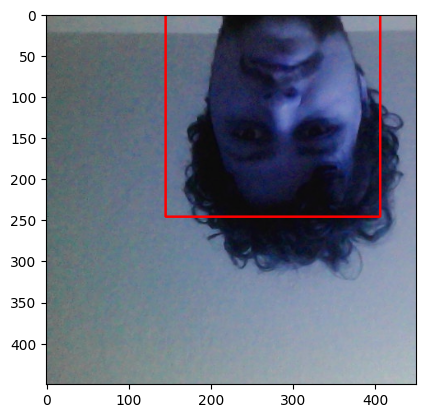

In [59]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Lancer le pipeline

### 5.1 Run Augmentation Pipeline

In [60]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try:
            for x in range(120):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6737132352941176, 0.9191176470588236, 0.34283088235294124, 0.3872549019607843, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [61]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [62]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [63]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [64]:
train_images.as_numpy_iterator().next()

array([[[0.4074755 , 0.41807598, 0.40539217],
        [0.41237745, 0.42022058, 0.41139707],
        [0.41911766, 0.4269608 , 0.41090685],
        ...,
        [0.6014706 , 0.5647059 , 0.51029414],
        [0.6117647 , 0.5622549 , 0.52585787],
        [0.6186274 , 0.5598039 , 0.5314338 ]],

       [[0.4248162 , 0.44754902, 0.43039215],
        [0.40998775, 0.4261642 , 0.42077205],
        [0.40030637, 0.41599265, 0.41207108],
        ...,
        [0.6148284 , 0.5568628 , 0.52996325],
        [0.6113971 , 0.5534314 , 0.53253675],
        [0.6254902 , 0.54834557, 0.5385417 ]],

       [[0.36102942, 0.3884804 , 0.35710785],
        [0.40876225, 0.4283701 , 0.40484068],
        [0.42346814, 0.44307598, 0.4204044 ],
        ...,
        [0.6132353 , 0.54656863, 0.5156863 ],
        [0.62395835, 0.5572917 , 0.5264093 ],
        [0.61194855, 0.5452819 , 0.5163603 ]],

       ...,

       [[0.4963848 , 0.51384807, 0.5036152 ],
        [0.5151348 , 0.5229167 , 0.5191789 ],
        [0.5338848 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [65]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [66]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [67]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [68]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [69]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4016, 0.    , 0.9087, 0.4912], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [70]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4920, 4920, 1200, 1200, 960, 960)

### 7.2 Create Final Datasets (Images/Labels)

In [71]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [72]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [73]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [74]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4697 , 0.509  , 0.7627 , 0.8696 ],
        [0.10956, 0.03452, 0.6035 , 0.6177 ],
        [0.4229 , 0.3394 , 0.867  , 0.9536 ],
        [0.1304 , 0.1447 , 0.525  , 0.631  ],
        [0.4138 , 0.3208 , 0.916  , 0.9194 ],
        [0.1477 , 0.097  , 0.6523 , 0.646  ],
        [0.3367 , 0.3372 , 0.776  , 0.9175 ],
        [0.1611 , 0.     , 0.637  , 0.602  ]], dtype=float16))

### 7.3 View Images and Annotations

In [75]:
data_samples = train.as_numpy_iterator()

In [76]:
res = data_samples.next()

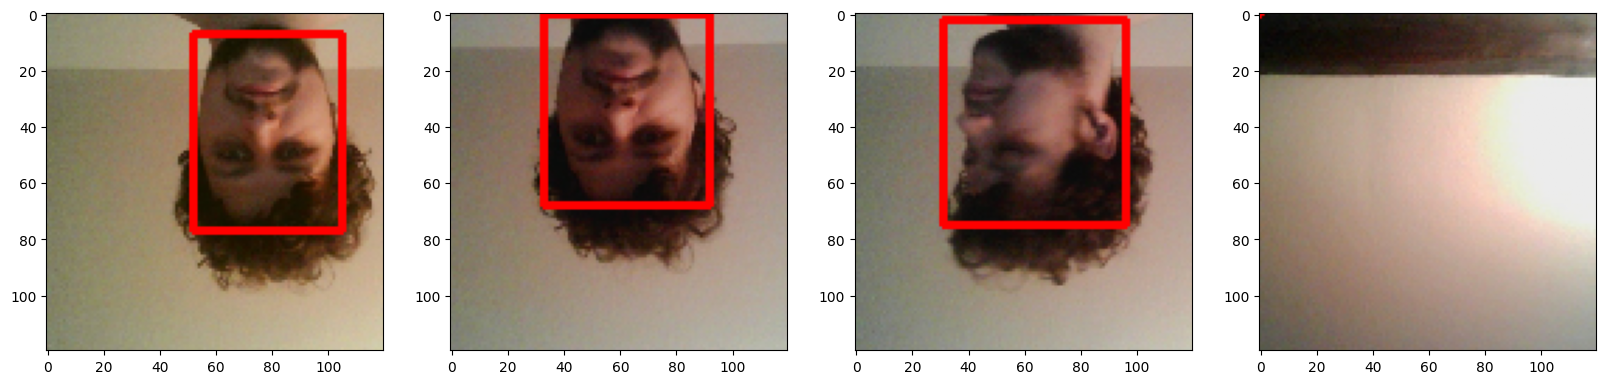

In [77]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [79]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [80]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [81]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [82]:
facetracker = build_model()

In [83]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [84]:
X, y = train.as_numpy_iterator().next()

In [85]:
X.shape

(8, 120, 120, 3)

In [86]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [87]:
classes, coords

(array([[0.6134603 ],
        [0.5963124 ],
        [0.5644881 ],
        [0.6160354 ],
        [0.626057  ],
        [0.6034666 ],
        [0.6438738 ],
        [0.62599283]], dtype=float32),
 array([[0.31646076, 0.55717784, 0.42818576, 0.4002248 ],
        [0.39432862, 0.48544815, 0.49273416, 0.4031985 ],
        [0.3587213 , 0.46172568, 0.35918012, 0.36547744],
        [0.3604822 , 0.4814244 , 0.41701207, 0.4185269 ],
        [0.33901355, 0.5334409 , 0.48307863, 0.34926438],
        [0.37600657, 0.49106222, 0.47535765, 0.3917236 ],
        [0.4019453 , 0.5214663 , 0.40010196, 0.4296903 ],
        [0.36806476, 0.4600565 , 0.45286515, 0.31842664]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [88]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [89]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 9.2 Create Localization Loss and Classification Loss

In [90]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [91]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [92]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.489842>

In [93]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7230523>

In [94]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.489842>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [95]:
class FaceTracker(Model):
    def __init__(self, eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [96]:
model = FaceTracker(facetracker)

In [97]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [98]:
logdir='logs'

In [99]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [100]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
615/615 [==============================] - 73s 69ms/step - total_loss: 0.0936 - class_loss: 0.0144 - regress_loss: 0.0864 - val_total_loss: 1.3325 - val_class_loss: 0.4901 - val_regress_loss: 1.0874
Epoch 2/10
615/615 [==============================] - 50s 66ms/step - total_loss: 0.0182 - class_loss: 6.0659e-05 - regress_loss: 0.0182 - val_total_loss: 1.2885 - val_class_loss: 0.7843 - val_regress_loss: 0.8963
Epoch 3/10
615/615 [==============================] - 50s 66ms/step - total_loss: 0.0110 - class_loss: 9.1812e-06 - regress_loss: 0.0110 - val_total_loss: 1.3491 - val_class_loss: 0.6311 - val_regress_loss: 1.0335
Epoch 4/10
615/615 [==============================] - 50s 67ms/step - total_loss: 0.0094 - class_loss: 5.4555e-06 - regress_loss: 0.0094 - val_total_loss: 0.2186 - val_class_loss: 0.0029 - val_regress_loss: 0.2172
Epoch 5/10
615/615 [==============================] - 49s 68ms/step - total_loss: 0.0080 - class_loss: 2.4757e-06 - regress_loss: 0.0080 - val_total

### 10.3 Plot Performance

In [101]:
hist.history

{'total_loss': [0.06954730302095413,
  0.012559309601783752,
  0.011733075603842735,
  0.01493598148226738,
  0.005555259063839912,
  0.0027186591178178787,
  0.0038382038474082947,
  0.00596383772790432,
  0.02598070539534092,
  0.02587924152612686],
 'class_loss': [2.5928859031409957e-05,
  5.737024366680998e-06,
  4.1276725823991e-06,
  6.1245223150763195e-06,
  3.7178715501795523e-06,
  7.4505820180093e-08,
  1.7136385395133402e-06,
  2.980232594040899e-08,
  2.795579712255858e-05,
  0.00014584737073164433],
 'regress_loss': [0.06953433901071548,
  0.012556441128253937,
  0.011731011793017387,
  0.014932919293642044,
  0.00555340014398098,
  0.002718621864914894,
  0.0038373470306396484,
  0.005963822826743126,
  0.02596672810614109,
  0.02580631710588932],
 'val_total_loss': [1.3325130939483643,
  1.2884509563446045,
  1.3490636348724365,
  0.2185986191034317,
  1.2082737684249878,
  0.23410314321517944,
  0.7320666909217834,
  0.6237297058105469,
  0.283600389957428,
  0.46260830

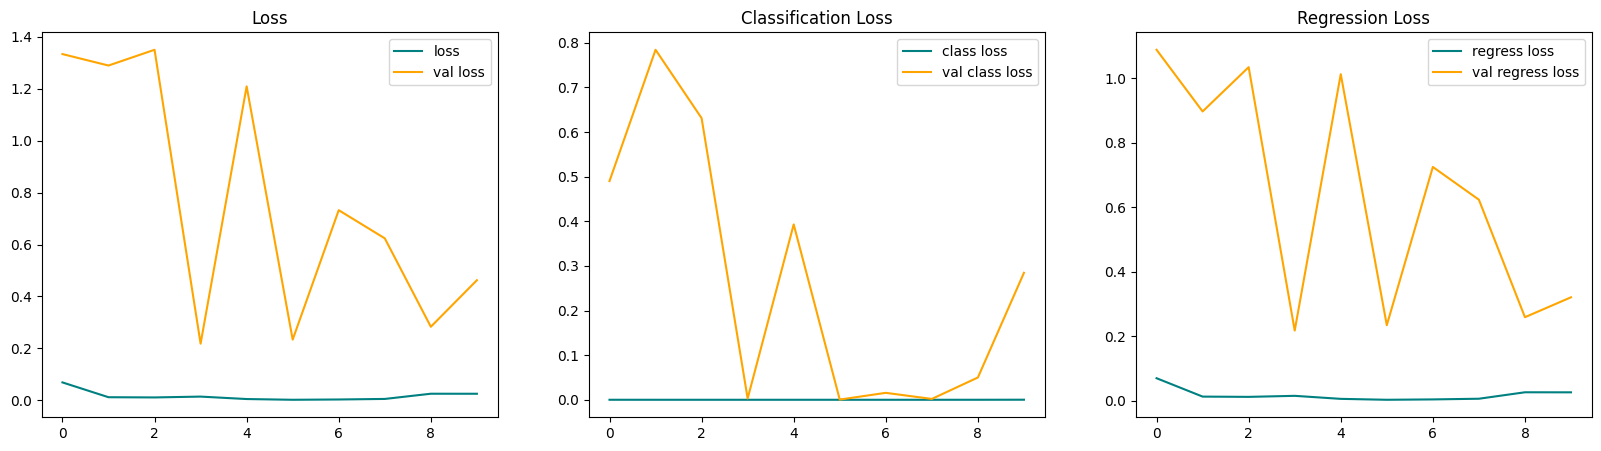

In [102]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [103]:
test_data = test.as_numpy_iterator()

In [104]:
test_sample = test_data.next()

In [105]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 18ms/step


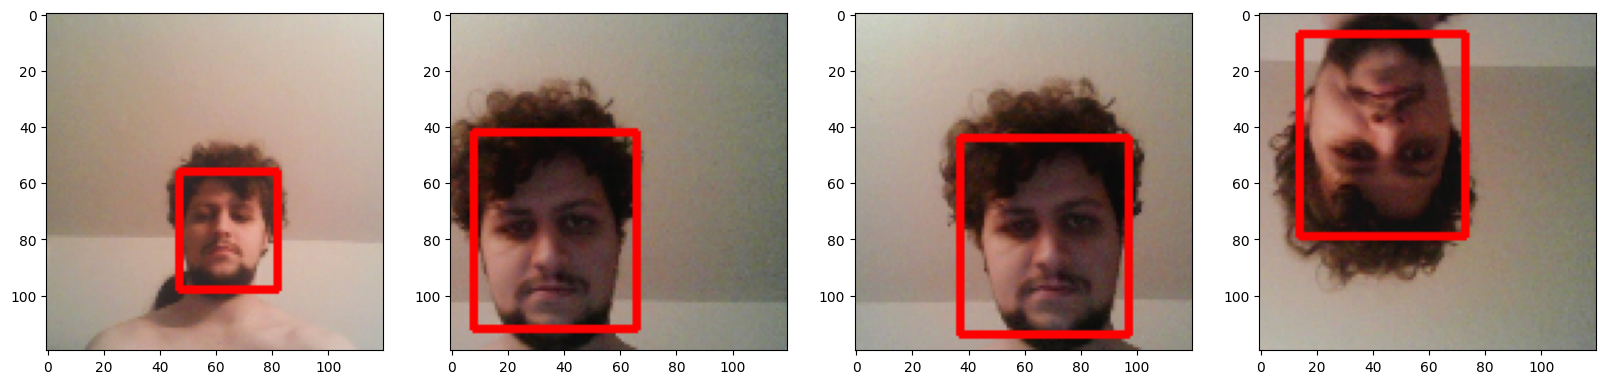

In [106]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                            (255,0,0), 2)

    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [107]:
from tensorflow.keras.models import load_model

In [108]:
facetracker.save('facetracker.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [109]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [110]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [111]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import tensorflow as tf

# Load the face recognition model
facetracker = load_model('facetracker.h5')

# Function to process a single frame
def process_frame(frame):
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [80, 0])),
                      (255, 0, 0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return frame

# Load a sample image (replace this with your video capture logic)
image_path = 'data/images/6cbc14ec-af31-11ee-9cbf-2cd26bf08388.jpg'
frame = cv2.imread(image_path)

# Process the frame
processed_frame = process_frame(frame)

# Display the processed frame
cv2_imshow(processed_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 [==============================] - 1s 846ms/step


NameError: name 'cv2_imshow' is not defined

In [115]:
video_path = 'data/images/video3.mp4'

In [113]:
video_path = 'data/images/video2.mp4'

In [116]:
from google.colab.patches import cv2_imshow

# Function to process a single frame
def process_frame(frame):
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                   [80, 0])),
                      (255, 0, 0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return frame

cap = cv2.VideoCapture(video_path)

# Process each frame of the video
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    # Process the frame
    processed_frame = process_frame(frame)

    # Display the processed frame
    cv2_imshow(processed_frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Output hidden; open in https://colab.research.google.com to view.